### Import Dataset
- Reads the dataset `game_statistics.csv` into a pandas DataFrame for analysis.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#CONSTS
READ_FOLDER_PATH = '../data/processed/'
WRITE_FOLDER_PATH = '../data/processed/'

data = pd.read_csv(READ_FOLDER_PATH+'game_statistics.csv')

print(data.shape[0])

941009


### Define Colours for Visualisations
Defines custom colour codes for use in plots:

In [12]:
COLOUR_WIN = '#00A807'
COLOUR_LOSE = '#F65348'
COLOUR_DRAW = 'lightsteelblue'
COLOUR_AXIS2 = 'darkslateblue'

### Plot Corner Frequencies Over Time
This function visualises the frequency of corners over the course of a game using time bins.

  - Filters only corner events (`event_type == 2`).
  - Creates time bins of equal intervals (e.g., 5, or 10 minutes)
  - Generates a bar chart showing the frequency of corners in each time bin (with frequency)

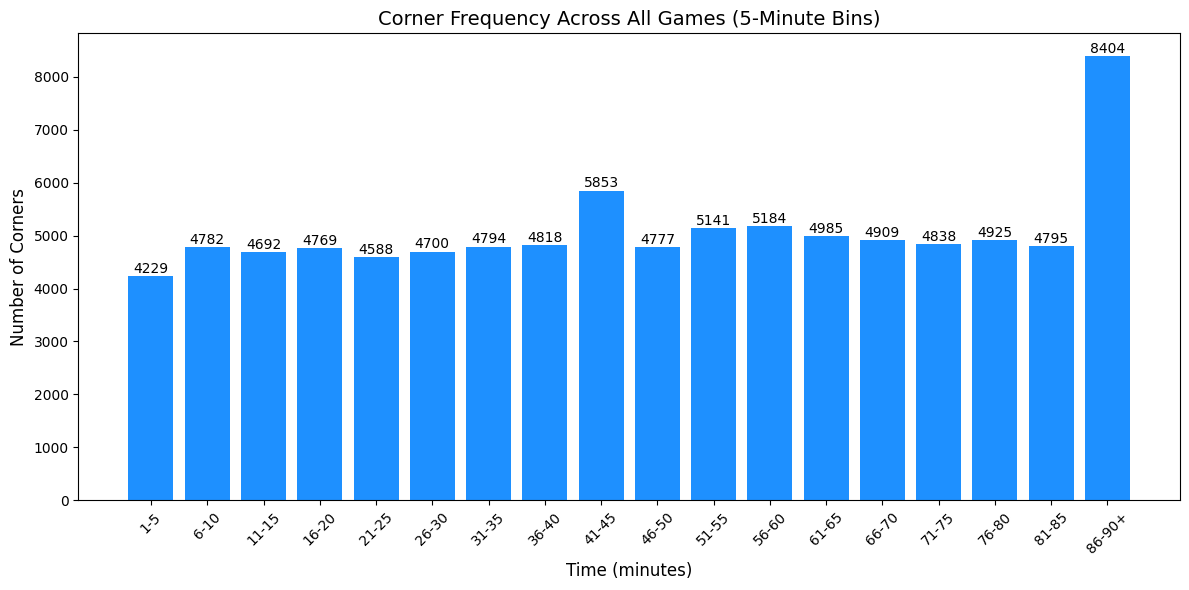

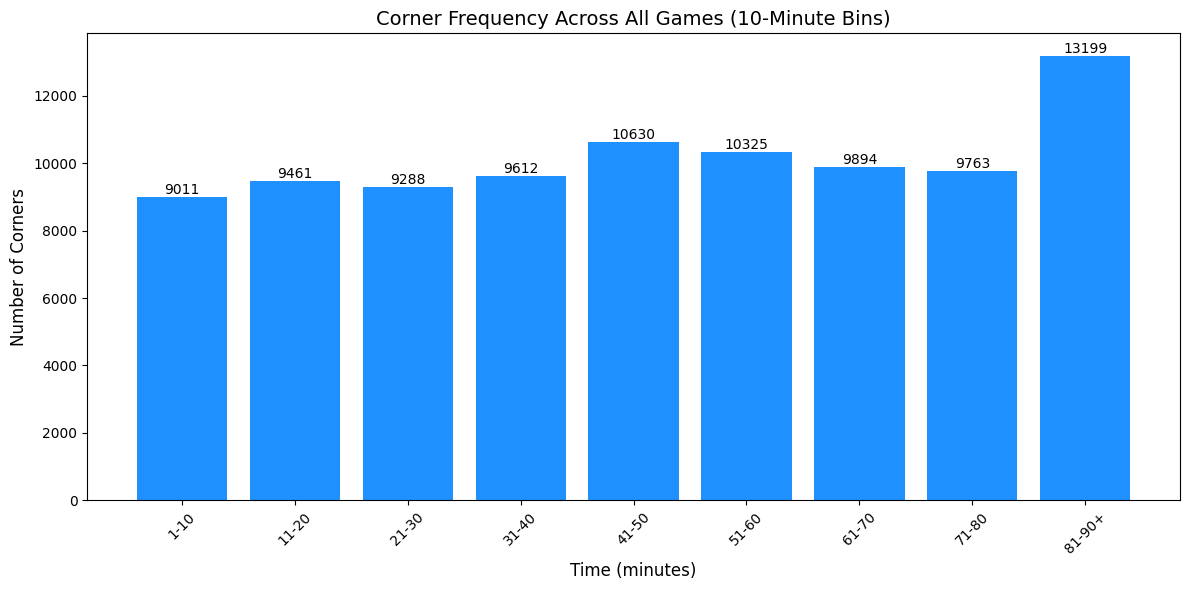

In [13]:
def plot_corner_frequencies_corrected(data, bin_size):
    #Filter for corner events
    corner_data = data[data['event_type'] == 2]

    #remove invalid or missing values
    corner_data = corner_data[corner_data['time'].notnull()]
    corner_data = corner_data[corner_data['time'] >= 0]  #nsure time values are valid

    #Define bins based on the bin size 
    bins = list(range(1, 91, bin_size)) + [float('inf')]  # 90+ as part of the last bin
    labels = [f"{bins[i]}-{bins[i+1]-1}" if bins[i+1] != float('inf') else f"{bins[i]}-90+" for i in range(len(bins)-1)] 
    #create a new column for time bins
    corner_data['time_bin'] = pd.cut(corner_data['time'], bins=bins,labels=labels, right=False) 

    #Count num of corners in each time bin... 
    corner_counts = corner_data['time_bin'].value_counts(sort=False)  
    

    #Plot graph
    plt.figure(figsize=(12, 6))
    bars = plt.bar(corner_counts.index.astype(str), corner_counts.values, width=0.8, color='dodgerblue')
    plt.title(f'Corner Frequency Across All Games ({bin_size}-Minute Bins)',fontsize=14)
    plt.xlabel('Time (minutes)',fontsize=12)
    plt.ylabel('Number of Corners',fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()


    # Add frequency labels on top of each bar:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() /2, bar.get_height()+1, str(int(bar.get_height())),
                 ha='center', va='bottom', fontsize=10)

 
    plt.show()

# Example usage for 5-minute and 10-minute bins with the corrected function
plot_corner_frequencies_corrected(data,5)
plot_corner_frequencies_corrected(data,10)

### Plot corner frequencies by game state
Graph which shows how corner frequencies change over the course of a match, split by game state (`winning`, `losing`, `drawing`) :
  - Shows the percentage of corners taken by losing teams over time.

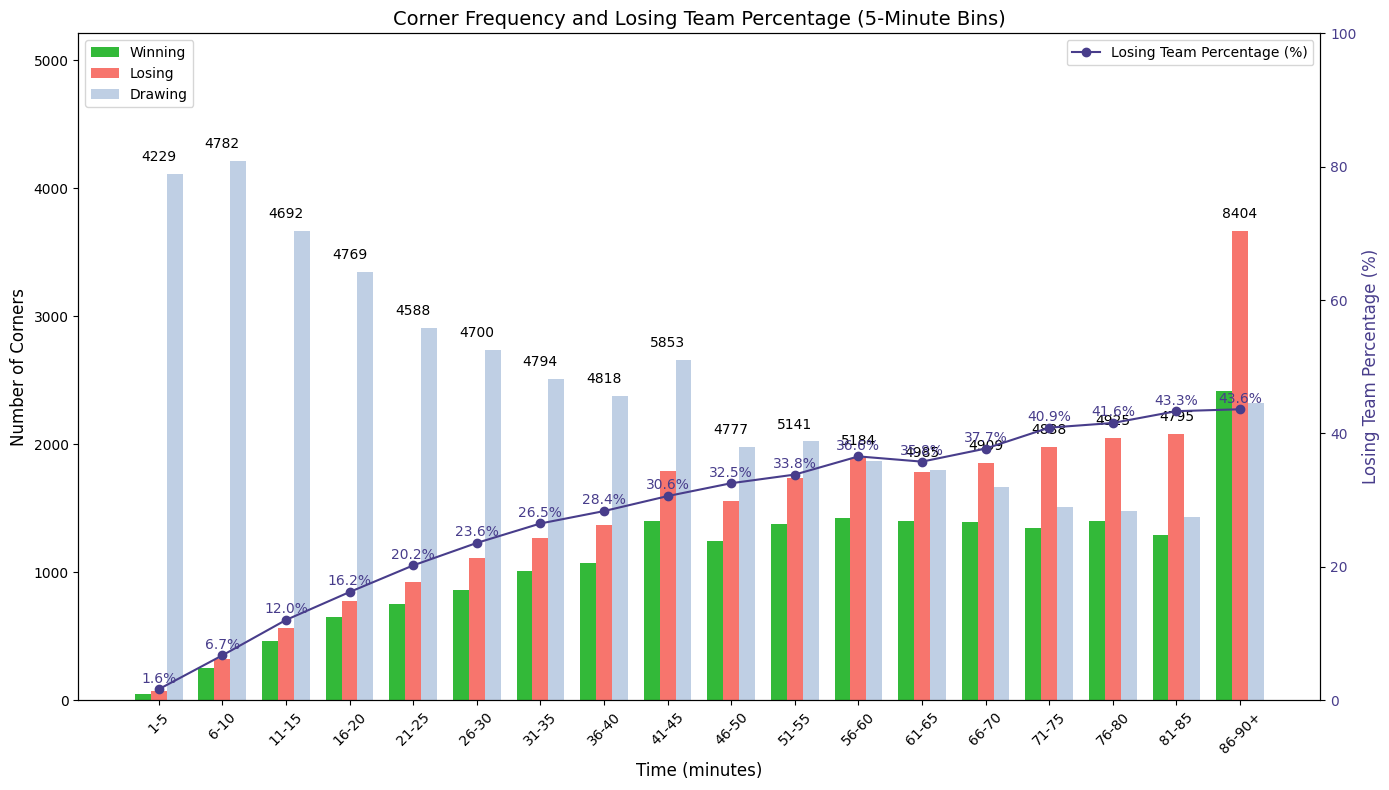

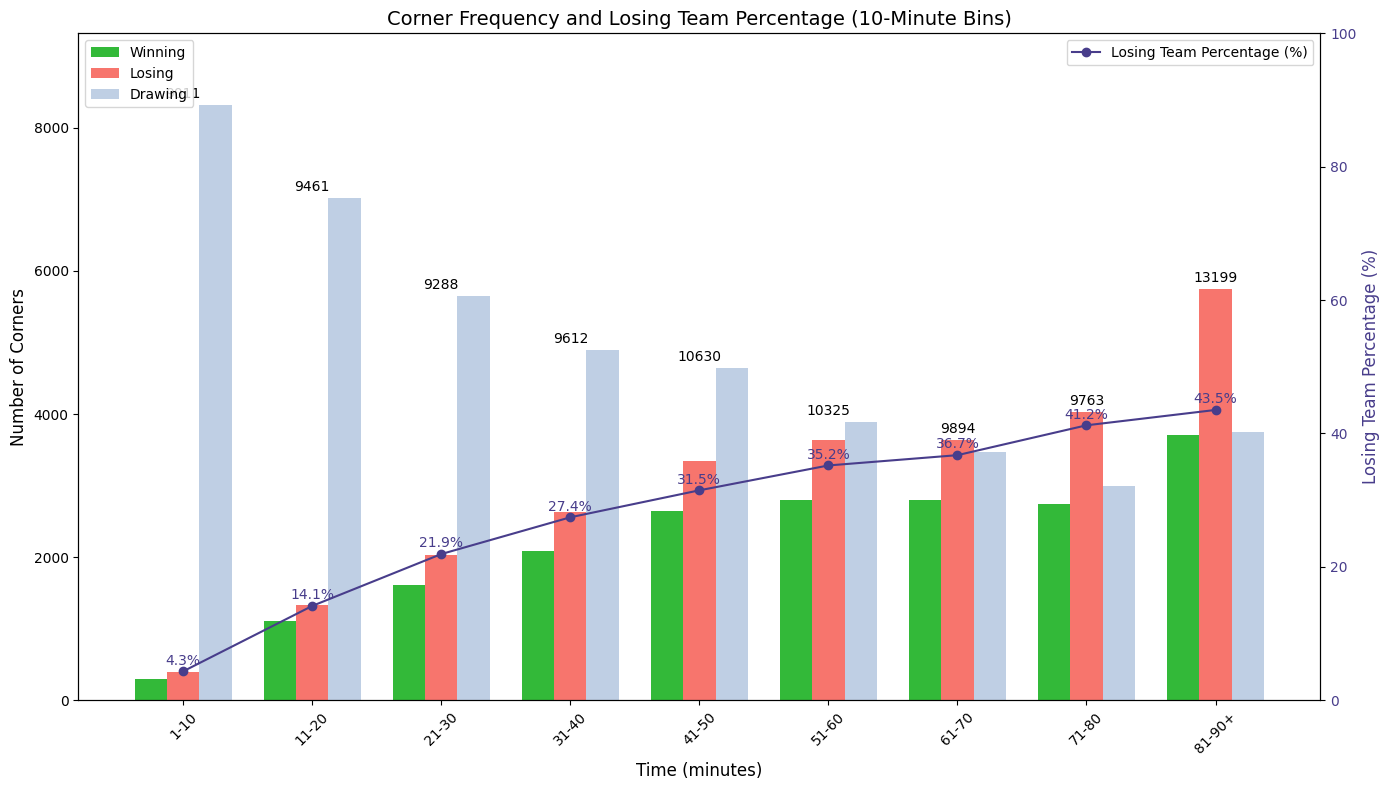

In [19]:
def plot_corner_frequencies_by_game_state(data, bin_size):
    #Validation: Make sure req columns are present 
    req_columns = ['time', 'event_type', 'score', 'side']
    if not all(col in data.columns for col in req_columns):
        raise ValueError(f"The dataset must contain the following columns: {req_columns}")

    corner_data = data[data['event_type'] == 2].copy()

    #Bins
    bins = list(range(1, 91, bin_size)) + [float('inf')]
    labels = [f"{bins[i]}-{bins[i+1]-1}" if bins[i+1] != float('inf') else f"{bins[i]}-90+" for i in range(len(bins)-1)]
    corner_data['time_bin'] =pd.cut(corner_data['time'], bins=bins,labels=labels, right=False)


    #Calculate total, corner and game state counts for each game state
    total_counts = corner_data['time_bin'].value_counts(sort=False)
    winning_corners = corner_data[corner_data['game_state'] == 'winning']
    losing_corners= corner_data[corner_data['game_state'] == 'losing']
    drawing_corners = corner_data[corner_data['game_state'] == 'drawing']
    winning_counts= winning_corners['time_bin'].value_counts(sort=False) 
    losing_counts = losing_corners['time_bin'].value_counts(sort=False)
    drawing_counts =drawing_corners['time_bin'].value_counts(sort=False)

    # Calculate the percentage of losing team corners  
    losing_percentage = (losing_counts /total_counts) * 100

    # Create a bar chart with grouped bars 
    x = np.arange(len(labels)) 
    bar_width = 0.25 

    #Grouped bar chart:
    fig, ax1 = plt.subplots(figsize=(14, 8)) 
    ax1.bar(x-bar_width, winning_counts.values, width=bar_width,label='Winning',alpha=0.8, color=COLOUR_WIN) 
    ax1.bar(x, losing_counts.values, width=bar_width,label='Losing', alpha=0.8, color=COLOUR_LOSE) 
    ax1.bar(x+bar_width,drawing_counts.values, width=bar_width,label='Drawing',alpha=0.8, color=COLOUR_DRAW)

    ax1.set_xlabel('Time (minutes)', fontsize=12)
    ax1.set_ylabel('Number of Corners',fontsize=12) 
    ax1.set_xticks(x) 
    ax1.set_xticklabels(labels, rotation=45) 

    #Add frequency labels at the top of the maximum bar in each group
    for pos in range(len(labels)):
        max_height = max(winning_counts.iloc[pos], losing_counts.iloc[pos], drawing_counts.iloc[pos])
        ax1.text(pos, max_height +100, str(total_counts.iloc[pos]),ha='center', fontsize=10)

    #Create secondary axis for losing percentage
    ax2 = ax1.twinx()
    ax2.plot(
        x, losing_percentage.values, color=COLOUR_AXIS2, marker='o',label='Losing Team Percentage (%)'
    ) 
    ax2.set_ylabel('Losing Team Percentage (%)',fontsize=12,color=COLOUR_AXIS2)
    ax2.tick_params(axis='y', labelcolor=COLOUR_AXIS2)
    #Add percentage labels on the line chart
    for pos, percent in enumerate(losing_percentage.values):
        if not np.isnan(percent):  #Avoid NaN vals
            ax2.text(pos, percent+1, f"{percent:.1f}%",ha='center',fontsize=10, color=COLOUR_AXIS2) 

    #set axis limits to scale graph properly...
    ax1.set_ylim(0, max(losing_counts.max(), winning_counts.max(),drawing_counts.max()) + 1000)
    ax2.set_ylim(0,100) 

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'Corner Frequency and Losing Team Percentage ({bin_size}-Minute Bins)', fontsize=14)
    
    fig.tight_layout()
    plt.show() 


#--- Call function ---
plot_corner_frequencies_by_game_state(data, 5)
plot_corner_frequencies_by_game_state(data, 10)

### Plot Shot Frequencies, Outcomes, and Accuracy
- Plots shot frequencies, outcomes, and accuracy over the course of a match.
- includes shot accuracy (percentage of shots on target) for each time interval.

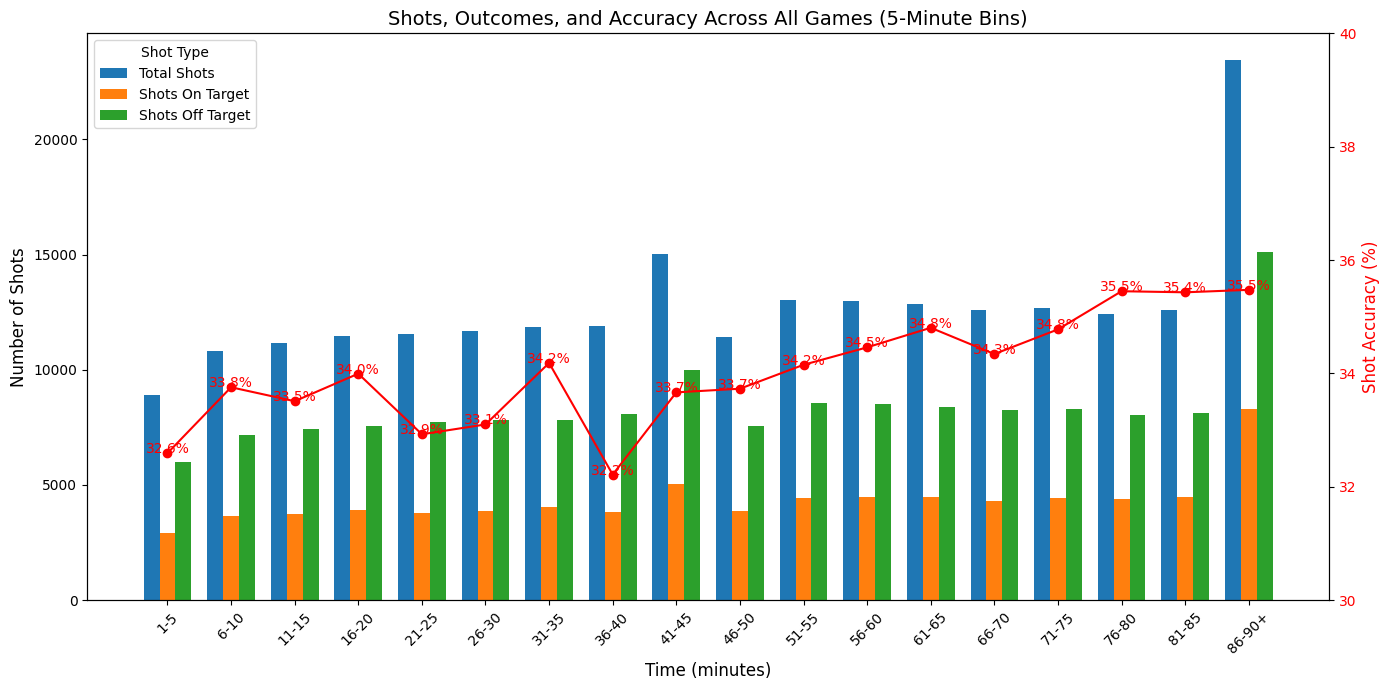

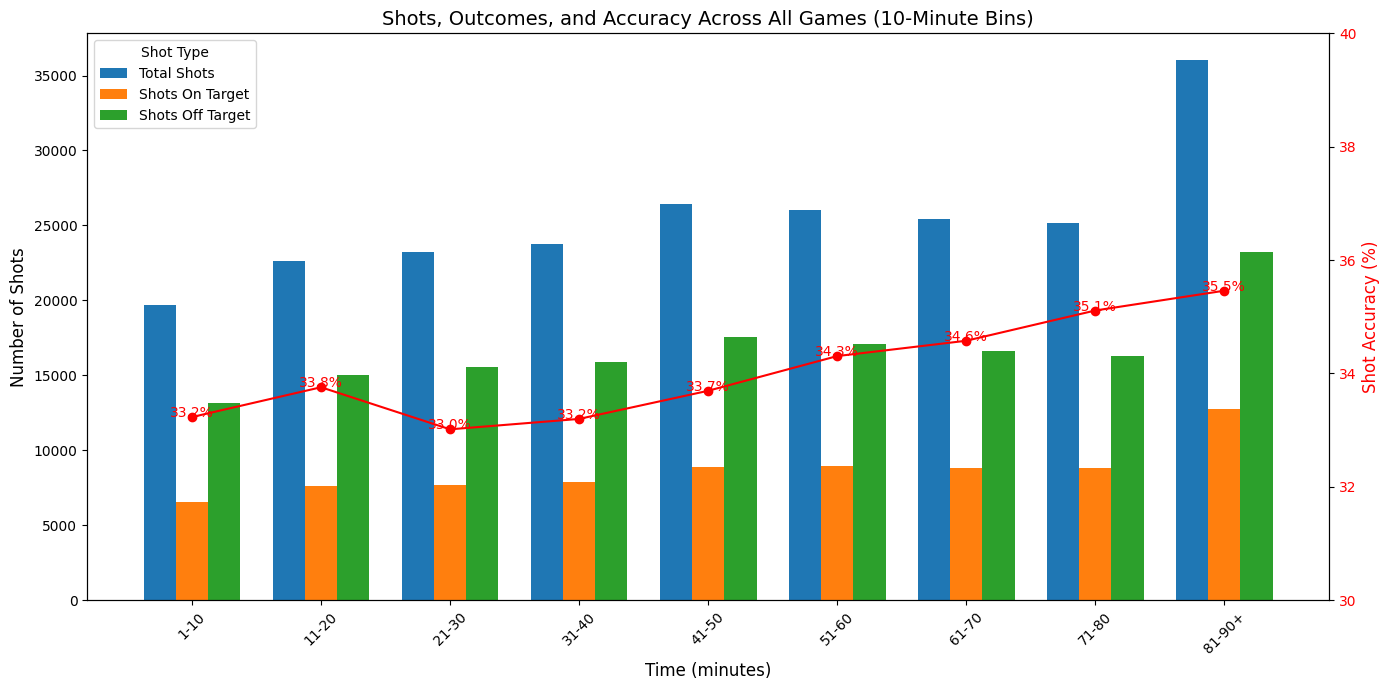

In [23]:
def plot_shots_frequencies(data, bin_size):
    #Validation: Make sure req columns are present 
    req_columns = ['time', 'event_type', 'shot_outcome']
    if not all(col in data.columns for col in req_columns):
        raise ValueError(f"The dataset must contain the following columns: {req_columns}")

    #Filter data by shots
    shots_data = data[data['event_type'] == 1]
    #Remove invalid or missing values in 'time' and 'shot_outcome'
    shots_data=shots_data[shots_data['time'].notnull() & shots_data['shot_outcome'].notnull()] 
    shots_data=shots_data[shots_data['time']>= 0] 
    
    #Bins
    bins = list(range(1, 91, bin_size)) + [float('inf')]
    labels = [f"{bins[i]}-{bins[i+1]-1}" if bins[i+1] != float('inf') else f"{bins[i]}-90+" for i in range(len(bins)-1)]
    shots_data['time_bin'] = pd.cut(shots_data['time'], bins=bins, labels=labels, right=False)
    
    #Categorise shot outcomes: on target (1), off-t (2, 3 or 4) 
    shots_data['shot_category'] = shots_data['shot_outcome'].apply(
        lambda x: 'Shots On Target' if x == 1 else 'Shots Off Target' if x in [2,3,4] else None
    )
 
    #Count occurrences for each shot category in each time bin
    counts = shots_data.groupby(['time_bin', 'shot_category'], observed=False).size().unstack(fill_value=0)
    counts['Total Shots'] = counts.sum(axis=1) #Append total column to end

    #Calc shot accuracy:
    counts['Accuracy'] = (counts['Shots On Target'] / counts['Total Shots']) *100 


    #Plot graph
    bar_width=0.25
    x = range(len(counts.index)) 
    fig, ax1 = plt.subplots(figsize=(14, 7)) 

    #Plot group bars
    for i, column in enumerate(['Total Shots', 'Shots On Target', 'Shots Off Target']):
        if column in counts:
            ax1.bar(
                [pos + i *bar_width for pos in x],
                counts[column], 
                width=bar_width,
                label=column
            )

            
    ax1.set_xlabel('Time (minutes)', fontsize=12)
    ax1.set_ylabel('Number of Shots', fontsize=12) 
    
    ax1.set_xticks([pos + bar_width for pos in x]) 
    ax1.set_xticklabels(counts.index.astype(str), rotation=45) 
    ax1.legend(title='Shot Type', fontsize=10, loc='upper left') 

    # Create secondary axis = shot accuracy (%)
    ax2 = ax1.twinx() 
    ax2.plot(
        [pos + bar_width for pos in x], 
        counts['Accuracy'], 
        color='red',
        marker='o', 
        label='Shot Accuracy (%)' 
    )    
    ax2.set_ylabel('Shot Accuracy (%)', fontsize=12, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
 

    #Add perc labels to line chart...
    for pos,time_bin in enumerate(counts.index):
        total =counts.loc[time_bin, 'Total Shots']
        if total > 0:
            accuracy = counts.loc[time_bin, 'Accuracy'] 
            ax2.text( 
                pos+bar_width,
                accuracy, 
                f"{accuracy:.1f}%",
                ha='center',
                fontsize=10, 
                color='red' 
            )  
   
    ax2.set_ylim(30, 40)  
    plt.title(f'Shots, Outcomes, and Accuracy Across All Games ({bin_size}-Minute Bins)', fontsize=14)
    fig.tight_layout()
    plt.show()


#--- Call function ---
plot_shots_frequencies(data, 5)
plot_shots_frequencies(data, 10)

### Plot Shots by Game State
Plots shot frequencies based on game state (`winning`, `drawing`, `losing`) over time:
- Groups shots into bins (e.g., 5 or 10-minute intervals) and categorises them by game state.
- Calculates the percentage of shots taken by losing teams for each time bin.
- Plots a grouped bar chart to compare shot counts for each game state.
- Overlays a line chart to highlight the percentage of shots taken by losing teams.

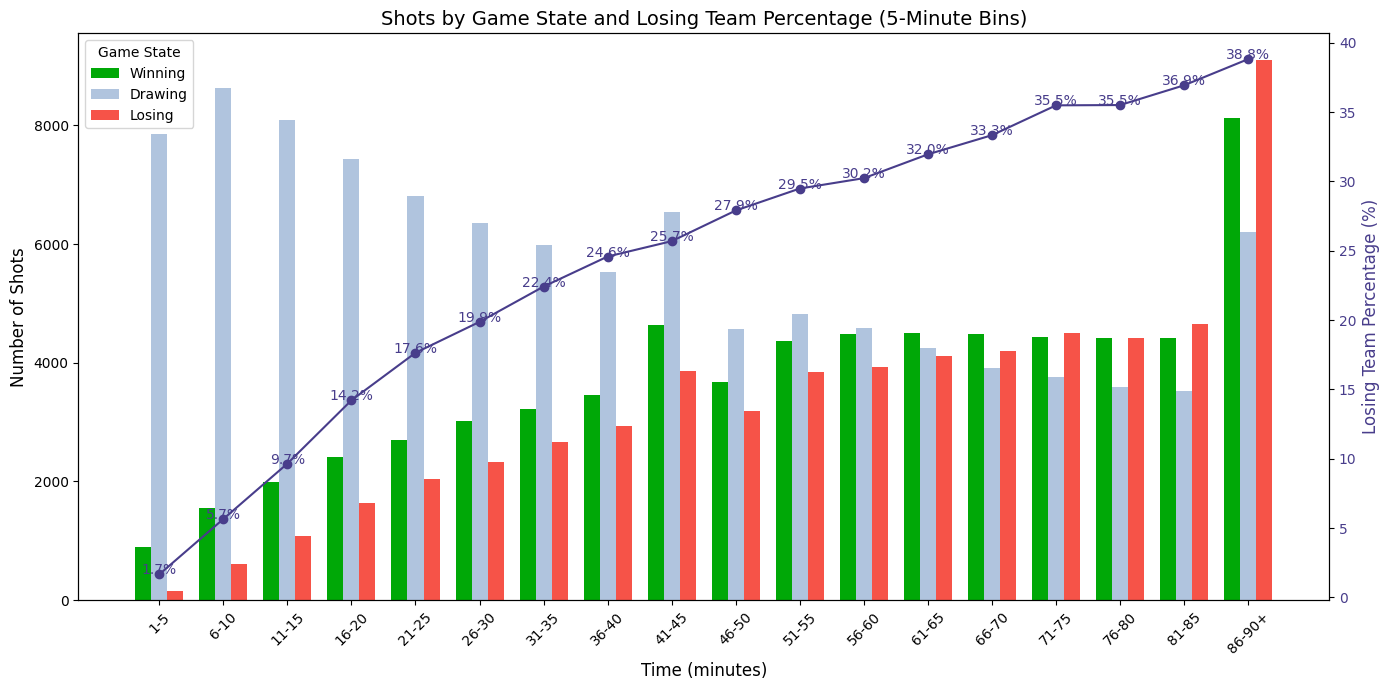

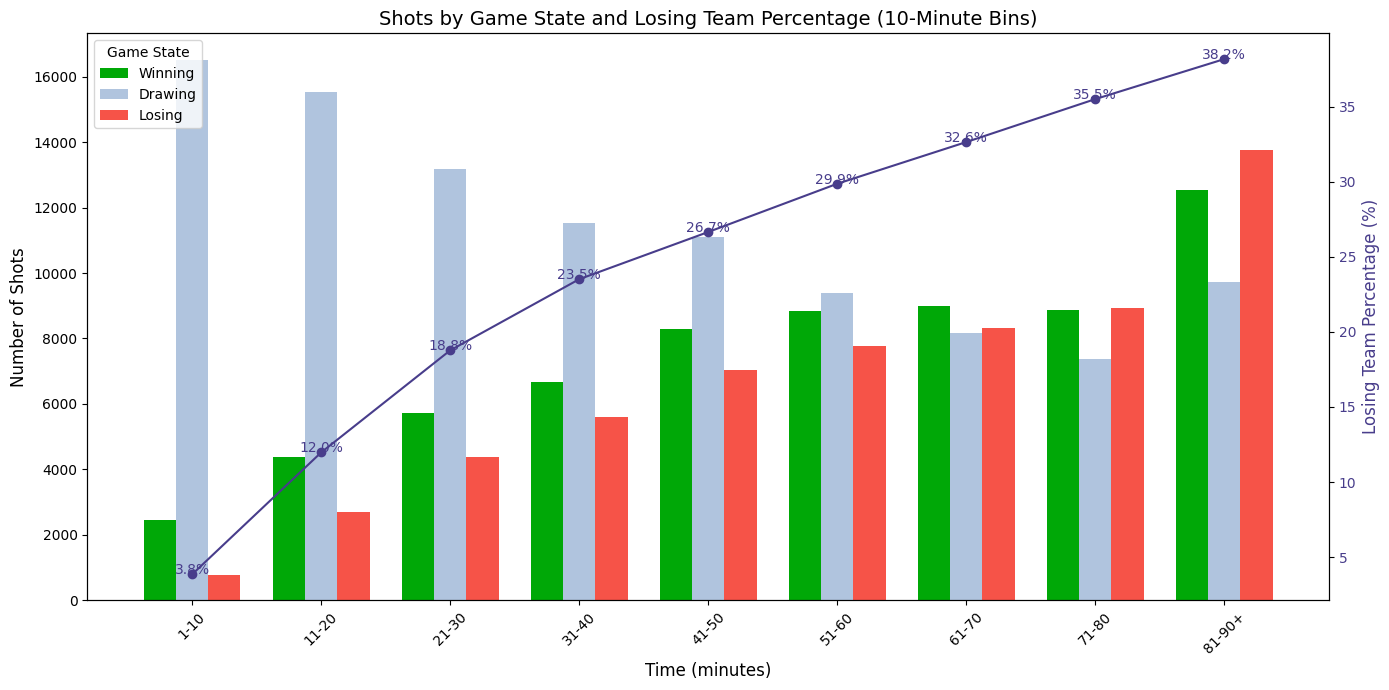

In [24]:
def plot_shots_by_game_state(data, bin_size):
    #Validation: Make sure req columns are present 
    req_columns = ['time', 'event_type', 'game_state']
    if not all(col in data.columns for col in req_columns):
        raise ValueError(f"The dataset must contain the following columns: {req_columns}")

    #Get shots column
    shots_data = data[data['event_type'] == 1]

    #Remove invalid or missing values in 'time' and 'shot_outcome'
    shots_data=shots_data[shots_data['time'].notnull() & shots_data['shot_outcome'].notnull()] 
    shots_data=shots_data[shots_data['time']>= 0] 

    #get shot bins
    bins = list(range(1, 91, bin_size)) + [float('inf')]
    labels = [f"{bins[i]}-{bins[i+1]-1}" if bins[i+1] != float('inf') else f"{bins[i]}-90+" for i in range(len(bins)-1)]
    shots_data['time_bin'] = pd.cut(shots_data['time'], bins=bins, labels=labels, right=False)

    #Count occurrences for each shot category in each time bin
    game_state_counts = shots_data.groupby(['time_bin', 'game_state'], observed=False).size().unstack(fill_value=0)
    game_state_counts['Total Shots'] = game_state_counts.sum(axis=1) #add a total column

    #Calculate the percentage of shots taken by losing teams
    game_state_counts['Losing Percentage'] = (game_state_counts['losing'] /game_state_counts['Total Shots']) *100   
    
    # --- Plot graph ---
    bar_width = 0.25
    x = range(len(game_state_counts.index))
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot bar group for winning, drawing, and losing
    colors = {'winning':COLOUR_WIN, 'drawing':COLOUR_DRAW, 'losing':COLOUR_LOSE} 
    for i, column in enumerate(['winning', 'drawing','losing']):
        if column in game_state_counts:  
            ax1.bar(
                [pos + i *bar_width for pos in x],
                game_state_counts[column],
                width=bar_width, 
                label=column.capitalize(),
                color=colors[column] 
            )
    
    ax1.set_xlabel('Time (minutes)',fontsize=12)
    ax1.set_ylabel('Number of Shots',fontsize=12)
    ax1.set_xticks([pos + bar_width for pos in x])
    ax1.set_xticklabels(game_state_counts.index.astype(str),rotation=45)
    ax1.legend(title='Game State', fontsize=10, loc='upper left')
 
    #Create secondary axis for losing percentage
    ax2 = ax1.twinx()
    ax2.plot( 
        [pos + bar_width for pos in x], #align to centre 
        game_state_counts['Losing Percentage'],
        color=COLOUR_AXIS2, 
        marker='o',
        label='Losing Team Percentage (%)' 
    )
    ax2.set_ylabel('Losing Team Percentage (%)',fontsize=12, color=COLOUR_AXIS2)
    ax2.tick_params(axis='y', labelcolor=COLOUR_AXIS2) 

    #Add percentage labels to line chart
    for pos, time_bin in enumerate(game_state_counts.index):
        losing_percentage = game_state_counts.loc[time_bin,'Losing Percentage']
        if not pd.isna(losing_percentage):  #Avoid NaN
            ax2.text(
                pos + bar_width,
                losing_percentage, 
                f"{losing_percentage:.1f}%",
                ha='center', 
                fontsize=10, 
                color=COLOUR_AXIS2
            ) 
 
    plt.title(f'Shots by Game State and Losing Team Percentage ({bin_size}-Minute Bins)', fontsize=14)
    fig.tight_layout()
    plt.show()

#--- Call function ---
plot_shots_by_game_state(data, 5)
plot_shots_by_game_state(data, 10)

### Plot yellow cards by Game State
Plots yellow card frequencies based on game state (`winning`, `drawing`, `losing`) over time:
- Groups yellow card events into bins (e.g., 5 or 10-minute intervals) and categorises them by game state.
- Calculates the percentage of yellow cards issued to losing teams for each time bin.
- Plots a grouped bar chart for yellow card counts by game state.
- Overlays a line chart to show the percentage of yellow cards given to losing teams.

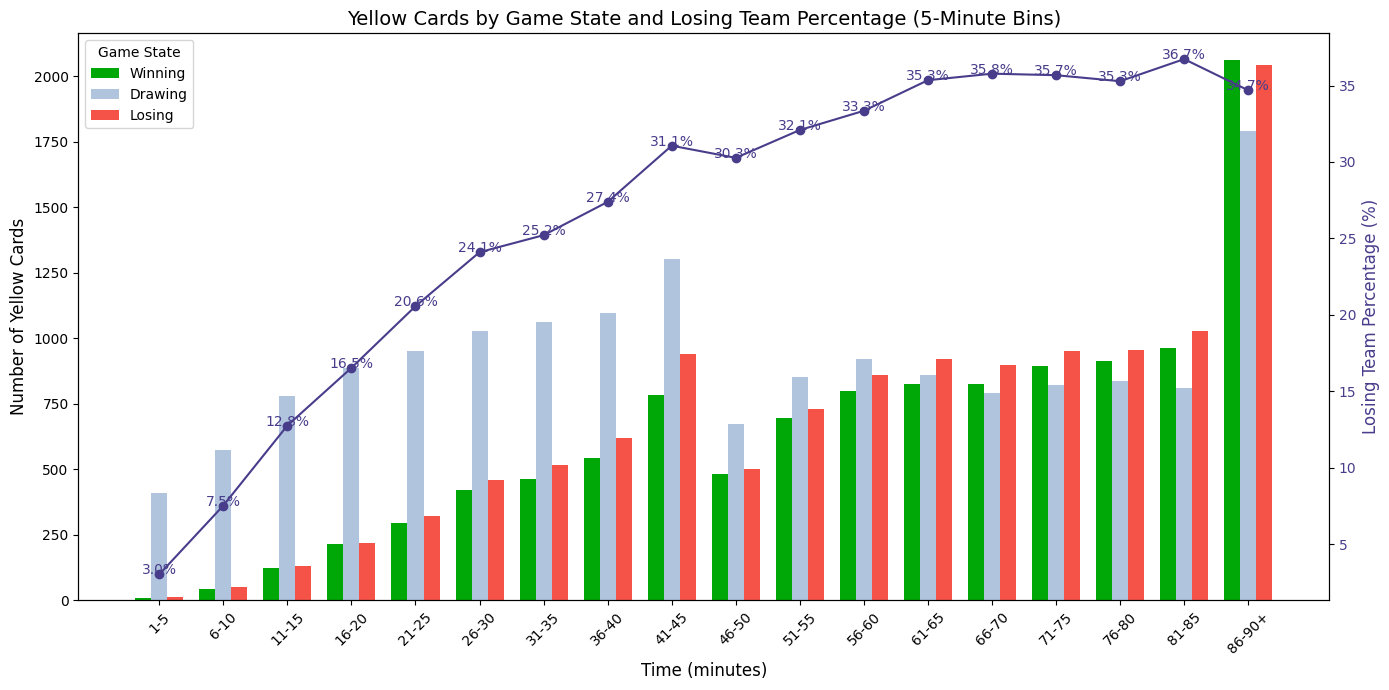

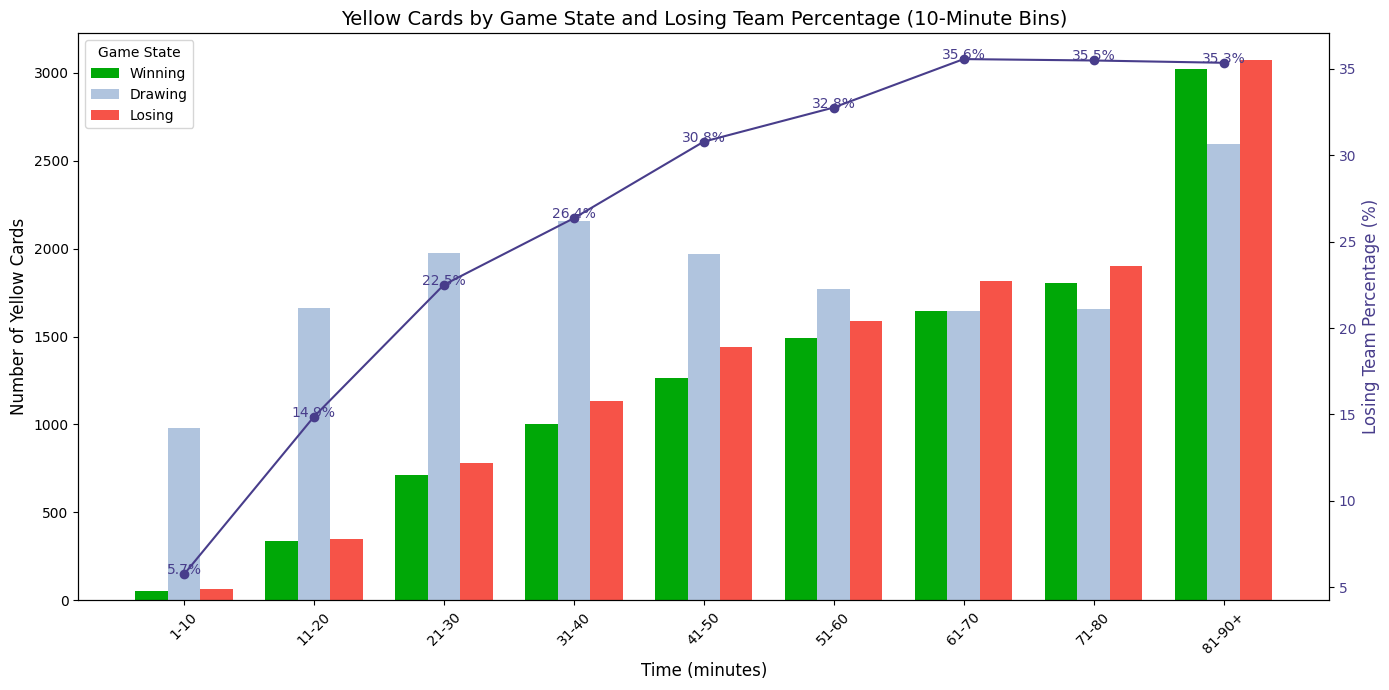

In [27]:
def plot_yellows_by_game_state(data, bin_size):
    #Validation: Make sure req columns are present 
    req_columns = ['time', 'event_type', 'game_state']
    if not all(col in data.columns for col in req_columns):
        raise ValueError(f"The dataset must contain the following columns: {req_columns}")

    # Filter data for yellow cards
    yellow_cards_data = data[data['event_type'] == 4]

    #Remove invalid or missing values in 'time' and 'shot_outcome' 
    yellow_cards_data=yellow_cards_data[yellow_cards_data['time'].notnull()] 
    yellow_cards_data=yellow_cards_data[yellow_cards_data['time'] >=0]   

    #get bins 
    bins = list(range(1, 91, bin_size)) + [float('inf')]
    labels = [f"{bins[i]}-{bins[i+1]-1}" if bins[i+1] != float('inf') else f"{bins[i]}-90+" for i in range(len(bins)-1)]
    yellow_cards_data['time_bin'] = pd.cut(yellow_cards_data['time'], bins=bins, labels=labels, right=False) 

    #Count occurrences for each shot category in each time bin
    game_state_counts = yellow_cards_data.groupby(['time_bin','game_state'], observed=False).size().unstack(fill_value=0) 
    game_state_counts['Total Yellow Cards'] = game_state_counts.sum(axis=1) 

    #Calculate the percentage of yellows taken by losing teams
    game_state_counts['Losing Percentage'] = (game_state_counts['losing'] /game_state_counts['Total Yellow Cards']) *100   
    
    # --- Plot graph ---
    bar_width = 0.25
    x = range(len(game_state_counts.index))
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot bar group for winning, drawing, and losing
    colors = {'winning':COLOUR_WIN, 'drawing':COLOUR_DRAW, 'losing':COLOUR_LOSE} 
    for i, column in enumerate(['winning', 'drawing','losing']):
        if column in game_state_counts:  
            ax1.bar(
                [pos + i *bar_width for pos in x],
                game_state_counts[column],
                width=bar_width, 
                label=column.capitalize(),
                color=colors[column] 
            )
    
    ax1.set_xlabel('Time (minutes)',fontsize=12)  
    ax1.set_ylabel('Number of Yellow Cards',fontsize=12)
    ax1.set_xticks([pos + bar_width for pos in x]) 
    ax1.set_xticklabels(game_state_counts.index.astype(str),rotation=45)
    ax1.legend(title='Game State', fontsize=10,loc='upper left') 
  
    #Create secondary axis for losing percentage
    ax2 = ax1.twinx()
    ax2.plot( 
        [pos + bar_width for pos in x], #align to centre 
        game_state_counts['Losing Percentage'],
        color=COLOUR_AXIS2, 
        marker='o',
        label='Losing Team Percentage (%)' 
    )
    ax2.set_ylabel('Losing Team Percentage (%)',fontsize=12, color=COLOUR_AXIS2)
    ax2.tick_params(axis='y', labelcolor=COLOUR_AXIS2) 

    #Add percentage labels to line chart
    for pos, time_bin in enumerate(game_state_counts.index):
        losing_percentage = game_state_counts.loc[time_bin,'Losing Percentage']
        if not pd.isna(losing_percentage):  #Avoid NaN
            ax2.text(
                pos + bar_width,
                losing_percentage, 
                f"{losing_percentage:.1f}%",
                ha='center', 
                fontsize=10, 
                color=COLOUR_AXIS2
            ) 
 
    plt.title(f'Yellow Cards by Game State and Losing Team Percentage ({bin_size}-Minute Bins)', fontsize=14)
    
    fig.tight_layout()
    plt.show()

#--- Call function ---
plot_yellows_by_game_state(data, 5)
plot_yellows_by_game_state(data, 10)

### Plot fouls by Game State
Plots foul frequencies based on game state (`winning`, `drawing`, `losing`) over time:
- Groups foul events into bins (e.g., 5 or 10-minute intervals) and categorises them by game state.
- Calculates the percentage of fouls committed by losing teams for each time bin.
- Plots a grouped bar chart for foul counts by game state.
- Overlays a line chart to show the percentage of fouls committed by losing teams.

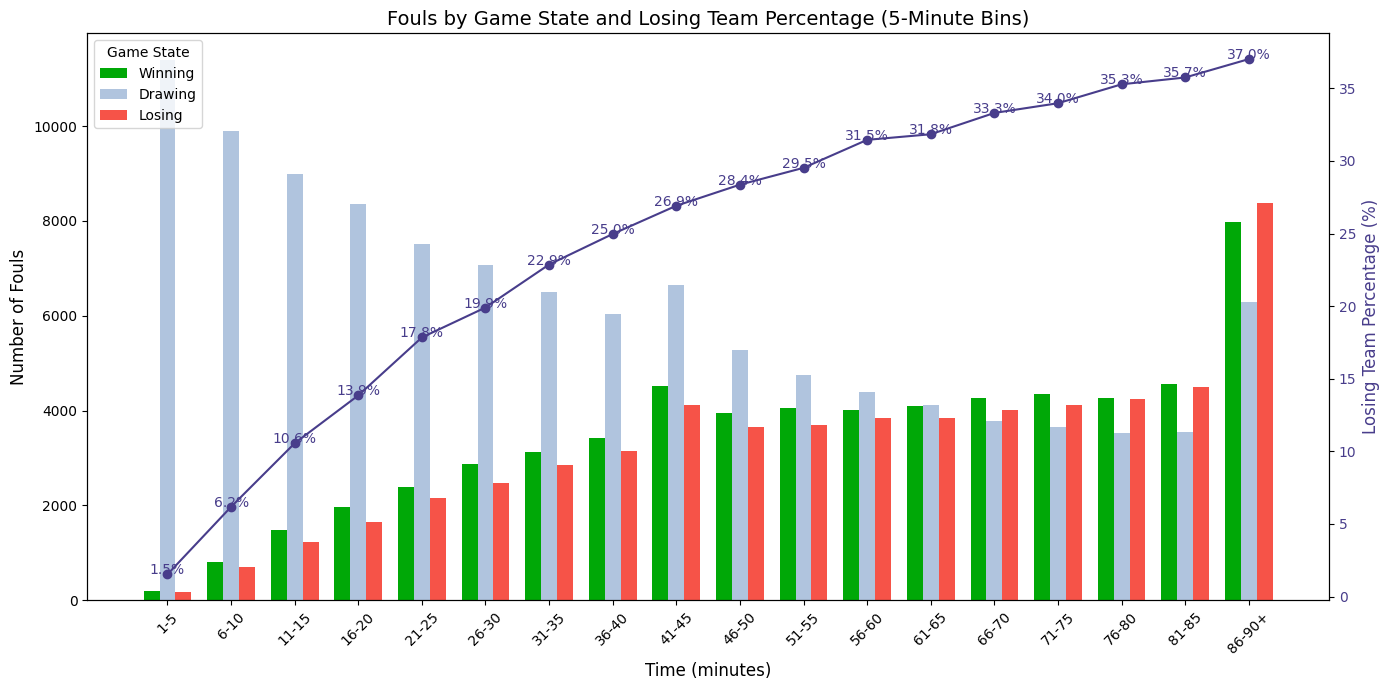

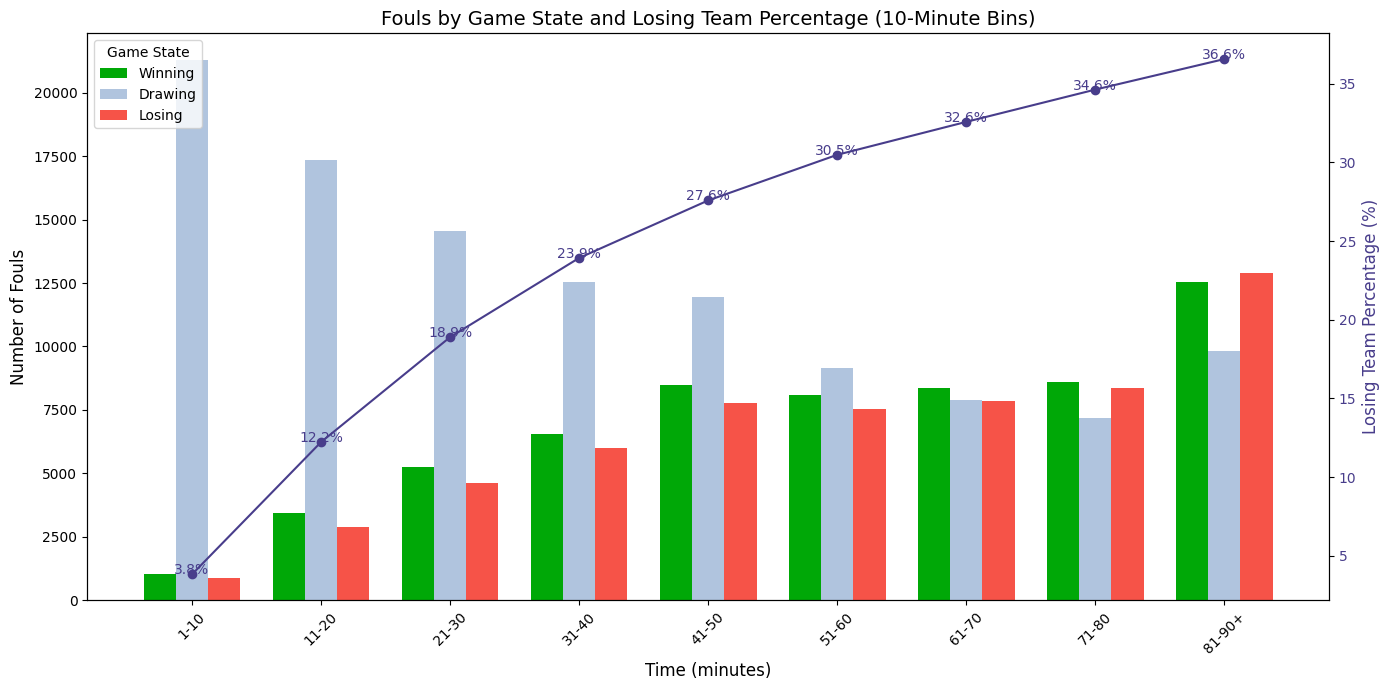

In [29]:
def plot_fouls_by_game_state(data, bin_size):
    #Validation: Make sure req columns are present 
    req_columns = ['time', 'event_type', 'game_state']
    if not all(col in data.columns for col in req_columns):
        raise ValueError(f"The dataset must contain the following columns: {req_columns}")

    # Filter data for fouls
    fouls_data = data[data['event_type'] == 3]

    #Remove invalid or missing values in 'time' and 'shot_outcome'
    fouls_data=fouls_data[fouls_data['time'].notnull()]
    fouls_data=fouls_data[fouls_data['time'] >= 0]

    #Get bins 
    bins = list(range(1, 91, bin_size)) + [float('inf')]
    labels = [f"{bins[i]}-{bins[i+1]-1}" if bins[i+1] != float('inf') else f"{bins[i]}-90+" for i in range(len(bins)-1)]
    fouls_data['time_bin'] = pd.cut(fouls_data['time'], bins=bins,labels=labels,right=False)

    #Count occurrences for each shot category in each time bin
    game_state_counts = fouls_data.groupby(['time_bin','game_state'], observed=False).size().unstack(fill_value=0) 
    game_state_counts['Total Fouls'] = game_state_counts.sum(axis=1) #Append total col

    #Calculate the percentage of yellows taken by losing teams
    game_state_counts['Losing Percentage'] = (game_state_counts['losing'] /game_state_counts['Total Fouls']) *100   
    
    # --- Plot graph ---
    bar_width = 0.25
    x = range(len(game_state_counts.index))
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot bar group for winning, drawing, and losing
    colors = {'winning':COLOUR_WIN, 'drawing':COLOUR_DRAW, 'losing':COLOUR_LOSE} 
    for i, column in enumerate(['winning', 'drawing','losing']):
        if column in game_state_counts:  
            ax1.bar(
                [pos + i *bar_width for pos in x],
                game_state_counts[column],
                width=bar_width, 
                label=column.capitalize(),
                color=colors[column] 
            )
    
    ax1.set_xlabel('Time (minutes)',fontsize=12)  
    ax1.set_ylabel('Number of Fouls',fontsize=12)
    ax1.set_xticks([pos + bar_width for pos in x]) 
    ax1.set_xticklabels(game_state_counts.index.astype(str),rotation=45)
    ax1.legend(title='Game State', fontsize=10,loc='upper left') 
  
    #Create secondary axis for losing percentage
    ax2 = ax1.twinx()
    ax2.plot( 
        [pos + bar_width for pos in x], #align to centre 
        game_state_counts['Losing Percentage'],
        color=COLOUR_AXIS2, 
        marker='o',
        label='Losing Team Percentage (%)' 
    )
    ax2.set_ylabel('Losing Team Percentage (%)',fontsize=12, color=COLOUR_AXIS2)
    ax2.tick_params(axis='y', labelcolor=COLOUR_AXIS2) 

    #Add percentage labels to line chart
    for pos, time_bin in enumerate(game_state_counts.index):
        losing_percentage = game_state_counts.loc[time_bin,'Losing Percentage']
        if not pd.isna(losing_percentage):  #Avoid NaN
            ax2.text(
                pos + bar_width,
                losing_percentage, 
                f"{losing_percentage:.1f}%",
                ha='center', 
                fontsize=10, 
                color=COLOUR_AXIS2
            ) 
 
    plt.title(f'Fouls by Game State and Losing Team Percentage ({bin_size}-Minute Bins)', fontsize=14)
    
    fig.tight_layout()
    plt.show()

#--- Call function ---
plot_fouls_by_game_state(data, 5)
plot_fouls_by_game_state(data, 10)